- Check for Colab Env
> if we are in colab env we need to get the data + scripts from github or somewhere

In [1]:
import os
if "COLAB_GPU" in os.environ:
    _useMultiProcessing = False
    os.system("git clone https://github.com/zaxo7/UNet-Playground.git")
    os.chdir("/content/UNet-Playground/")
else:
    _useMultiProcessing = True
    
if "PAPERSPACE_FQDN" in os.environ:
    !apt update
    !apt install libgl1 -y
    !pip install opencv-python 
    #!git pull
    !pip install line_profiler
    !pip install memory_profiler


- enable module autoreload and fix an import bug

In [2]:
%load_ext autoreload
%autoreload 2

import sys,os
sys.path.append(os.getcwd() + '/scripts')

- import the scripts and data

In [2]:
from scripts import data, model
import glob
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import cv2
import numpy as np

2022-05-17 20:31:57.634944: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/zaxo7/tensorflow/lib/python3.8/site-packages/cv2/../../lib64:
2022-05-17 20:31:57.634982: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


- load the dataset
- and ceate image slices

- slice each image to small samples of size 188*188
- imgs -> rgb image
- mask -> mask
- edge -> edge_mask

In [4]:
%load_ext line_profiler
%load_ext memory_profiler

train_img_files = sorted(glob.glob('data/train/*.jpg'))
train_mask_label_files = sorted(glob.glob('data/train/mask/*.jpg'))
train_edge_label_files = sorted(glob.glob('data/train/edge/*.jpg'))

test_img_files = sorted(glob.glob('data2/test/*.jpg'))
test_mask_label_files = sorted(glob.glob('data2/test/mask/*.jpg'))
test_edge_label_files = sorted(glob.glob('data2/test/edge/*.jpg'))

In [5]:
len(test_img_files)

33

In [8]:
def test():
    imgs = []
    for img in  train_img_files:
        imgs += [cv2.imread(img)]
        
    imgs = data.preprocess_data_na(imgs, padding=200, RGB=True)
    return imgs
        
%memit test()

peak memory: 2350.43 MiB, increment: 1953.23 MiB


In [5]:
%mprun -f data.load_image_list  data.load_image_list(train_img_files, RGB=False)
%memit  imgs = data.load_image_list(train_img_files, RGB=False)


peak memory: 443.98 MiB, increment: 33.21 MiB


Filename: /notebooks/scripts/data.py

Line #    Mem usage    Increment  Occurrences   Line Contents
    13    408.5 MiB    408.5 MiB           1   def load_image_list(img_files, RGB=False):
    14    408.5 MiB      0.0 MiB           1       imgs = []
    15    443.8 MiB      0.0 MiB          11       for image_file in img_files:
    16    439.0 MiB      0.0 MiB          10           if RGB:
    17                                                     img = cv2.imread(image_file)
    18                                                 else:
    19    443.8 MiB     35.2 MiB          10               img = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)
    20    443.8 MiB      0.0 MiB          10               thresh = 127
    21    443.8 MiB      0.0 MiB          10               img = cv2.threshold(img, thresh, 255, cv2.THRESH_BINARY)[1]
    22                                                     
    23    443.8 MiB      0.0 MiB          10           imgs += [img]
    24    443.8 MiB      0.

In [5]:
%mprun -f data.load_data_na  imgs = data.load_data_na(train_mask_label_files)



Filename: /notebooks/scripts/data.py

Line #    Mem usage    Increment  Occurrences   Line Contents
   129    396.7 MiB    396.7 MiB           1   def load_data_na(img_list, edge_size=2, padding=200, RGB=False, clahe=False):
   130    672.1 MiB    275.4 MiB           1       img_list = load_image_list(img_list, RGB=RGB)
   131    672.1 MiB      0.0 MiB           1       if clahe:
   132                                                 img_list = clahe_images(img_list)
   133                                                 
   134   1062.1 MiB    390.0 MiB           1       img_list = preprocess_data_na(img_list, padding=padding, RGB=RGB)
   135                                         
   136   1062.1 MiB      0.0 MiB           1       return img_list

- create tiles and save em on disk

In [9]:
test_img_files = sorted(glob.glob('data2/test/*.jpg'))
test_mask_label_files = sorted(glob.glob('data2/test/mask/*.jpg'))
test_edge_label_files = sorted(glob.glob('data2/test/edge/*.jpg'))

for i in np.arange(len(test_img_files)):
    imgs, mask, edge = data.load_data3([test_img_files[i]], [test_mask_label_files[i]], [test_mask_label_files[i]])
    
    img_chip, mask_chip, edge_chip = data.test_chips(imgs, mask, edge=edge, padding=100, input_size=188, output_size=100)
    
    Image_name = test_img_files[i].split('/')[-1].split('.')[-1]
    rootPath="data2/test/"
    
    for j in np.arange(len(imgs)):
        cv2.imwrite(f"{rootPath}tiles/{Image_name}_{j}.jpg", (img_chip[j] + 1) * 255.0)
        

Im037_0.jpg
Im045_0.jpg
Im053_1.jpg
Im079_0.jpg
Im080_0.jpg
Im081_0.jpg
Im082_0.jpg
Im083_0.jpg
Im084_0.jpg
Im085_0.jpg
Im086_0.jpg
Im087_0.jpg
Im088_0.jpg
Im089_0.jpg
Im090_0.jpg
Im091_0.jpg
Im092_0.jpg
Im093_0.jpg
Im094_0.jpg
Im095_0.jpg
Im096_0.jpg
Im097_0.jpg
Im098_0.jpg
Im099_0.jpg
Im100_0.jpg
Im101_0.jpg
Im102_0.jpg
Im103_0.jpg
Im104_0.jpg
Im105_0.jpg
Im106_0.jpg
Im107_0.jpg
Im108_0.jpg


In [8]:
#imgs, mask, edge = data.load_data3(train_img_files, train_mask_label_files, train_mask_label_files)

print(len(imgs))
print(len(mask))
print(len(edge))

imgs_chunks = data.chunks(imgs, 33)
mask_chunks = data.chunks(mask, 33)
edge_chunks = data.chunks(edge, 33)

print(len(imgs_chunks))
print(len(mask_chunks))
print(len(edge_chunks))


img_chips = None
mask_chips = None
edge_chips = None

#for i in np.arange(len(imgs_chunks)):
i = 0
img_chip, mask_chip, edge_chip = data.test_chips(imgs_chunks[i], mask_chunks[i], edge=edge_chunks[i], padding=100, input_size=188, output_size=100)

# print(imgs_chunks[i].shape)
# print(mask_chunks[i].shape)
# print(edge_chunks[i].shape)

print(img_chip.shape)
print(mask_chip.shape)
print(edge_chip.shape)

# exit()

# if i == 0:
#     img_chips = img_chip
#     mask_chips = mask_chip
#     edge_chips = edge_chip
# else:
#     img_chips = np.concatenate((img_chips, img_chip), axis=0)
#     mask_chips = np.concatenate((mask_chips, mask_chip), axis=0)
#     edge_chips = np.concatenate((edge_chips, edge_chip), axis=0)

# print(f"chunk num {i} sliced succesfuly")
 

33
33
33
1
1
1


In [4]:
imgs, mask, edge = model.generate_test_dataset3_(train_img_files, train_mask_label_files, train_mask_label_files)

/notebooks/scripts/data.py:315: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mask_chips = np.array(mask_chips)
/notebooks/scripts/data.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  edge_chips = np.array(edge_chips)


(2980, 188, 188, 3)
(2980,)
(2980,)
chunk num 0 sliced succesfuly
(3832, 188, 188, 3)
(3832,)
(3832,)
chunk num 1 sliced succesfuly
(3548, 188, 188, 3)
(3548,)
(3548,)
chunk num 2 sliced succesfuly
(3264, 188, 188, 3)
(3264,)
(3264,)
chunk num 3 sliced succesfuly
(3264, 188, 188, 3)
(3264, 100, 100, 1)
(3264, 100, 100, 1)


ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 4 dimension(s)

In [13]:
new = np.concatenate((imgs[0], imgs[1]), axis=0)
new.shape

(6812, 188, 188, 3)

In [ ]:
%mprun -f model.generate_test_dataset3_ model.generate_test_dataset3_(train_img_files, train_mask_label_files, train_mask_label_files)

In [9]:

train_img_files = glob.glob('data2/train/*.jpg')
train_mask_label_files = glob.glob('data2/train/mask/*.jpg')
train_edge_label_files = glob.glob('data2/train/edge/*.jpg')

test_img_files = glob.glob('data2/test/*.jpg')
test_mask_label_files = glob.glob('data2/test/mask/*.jpg')
test_edge_label_files = glob.glob('data2/test/edge/*.jpg')

#train = model.generate_train_dataset3(train_img_files, train_mask_label_files, train_mask_label_files)

#train_set = model.generate_train_dataset3_tf(train_img_files, train_mask_label_files, train_edge_label_files)


# train_generator = model.generate_train_dataset(train_img_files)

# train_set = model.generate_train_dataset_tf(train_img_files)

#test_img_chips, test_mask_chips, test_edge_chips = model.generate_test_dataset3(test_img_files, test_mask_label_files, test_mask_label_files)

train_img_chips, train_mask_chips, train_edge_chips = model.generate_test_dataset3(train_img_files, train_mask_label_files, train_mask_label_files)

#test_set = tf.data.Dataset.from_tensor_slices((test_img_chips, (test_mask_chips, test_edge_chips)))


KeyboardInterrupt: 

In [11]:
len(test_img_files)

33

In [ ]:
ind = np.random.randint(0, len(test_img_chips), 1)[0]
fig = plt.figure(figsize=(15, 10), dpi=80)
fig.subplots_adjust(hspace=0.1, wspace=0.1)
ax = fig.add_subplot(2, 3, 1)
ax.imshow(test_img_chips[ind])
ax = fig.add_subplot(2, 3, 2)
ax.imshow(test_mask_chips[ind])
ax = fig.add_subplot(2, 3, 3)
ax.imshow(test_edge_chips[ind])

In [ ]:
try:
        img, (mask, edge) = next(test)
except StopIteration:
        pass


fig = plt.figure(figsize=(15, 10), dpi=80)
fig.subplots_adjust(hspace=0.1, wspace=0.1)
ax = fig.add_subplot(2, 3, 1)
ax.imshow(img)
ax = fig.add_subplot(2, 3, 2)
ax.imshow(mask)
ax = fig.add_subplot(2, 3, 3)
ax.imshow(edge)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


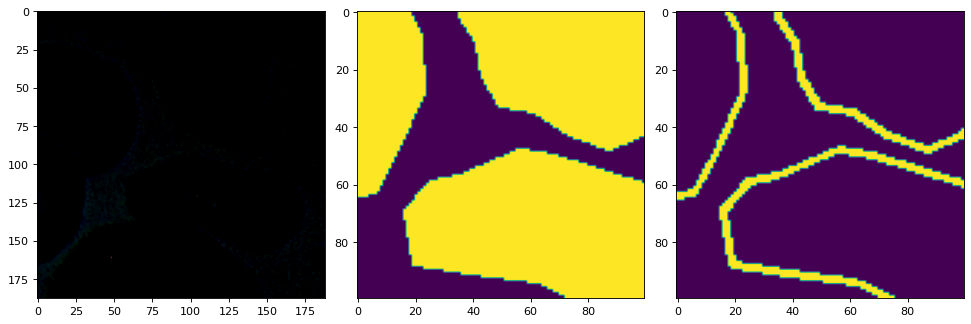

In [68]:
train_img_chips, (train_mask_chips, train_edge_chips) =  next(train)

fig = plt.figure(figsize=(15, 10), dpi=80)
fig.subplots_adjust(hspace=0.1, wspace=0.1)
ax = fig.add_subplot(2, 3, 1)
ax.imshow(train_img_chips)
ax = fig.add_subplot(2, 3, 2)
ax.imshow(np.squeeze(train_mask_chips))
ax = fig.add_subplot(2, 3, 3)
ax.imshow(np.squeeze(train_edge_chips))

- create the model and compile it

In [69]:
unet = model.get_do_unet(compile = False)

unet.compile(optimizer="adam",
             loss=model.tversky_loss,
             loss_weights=[1, 0],
             metrics={'mask': [model.mean_iou, model.dsc, model.tversky, model.tversky_b, 'acc'], 
                      'edge': [model.mean_iou, model.dsc, model.tversky, model.tversky_b, 'acc']})

unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 188, 188, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 186, 186, 96  2688        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 186, 186, 96  384        ['conv2d[0][0]']                 
 alization)                     )                                                             

- model parameters

In [82]:
_batch_size = 8
_epochs = 5
_workers = 8
_model_name = 'B'
images_per_epoch = 1000
train_steps = images_per_epoch//_batch_size
validation_steps = len(test_img_files)//_batch_size

Train = True

- load weights

In [83]:
unet.load_weights(f"models/{_model_name}_best.h5")

- Train the model

In [ ]:
if Train:
    history = unet.fit(train_set.batch(_batch_size), 
            epochs=_epochs, 
            validation_data=test_set.batch(_batch_size), 
            steps_per_epoch=train_steps,
            max_queue_size=2*_workers,
            use_multiprocessing=_useMultiProcessing,
            workers=_workers,
            verbose=1,
            callbacks=model.get_callbacks(_model_name))

- save the training log 

In [29]:
#save the training log into a file
import json
my_dict = {'a':11,'b':22,'c':33}
with open(f"models/{_model_name}_log.json", "a+") as fp:
    json.dump(history.history,fp)

# Opening JSON file
with open(f"models/{_model_name}_log.json") as fp:
  # returns JSON object as
  # a dictionary
  loaded_hist = json.load(fp)

In [84]:
rand_index = np.random.randint(0, len(test_img_chips), 1)[0]
img = test_img_chips[rand_index]
mask = np.squeeze(test_mask_chips[rand_index])
edge = np.squeeze(test_edge_chips[rand_index])


img = np.array([np.squeeze(img)])

prediction = unet.predict(img)

prediction = np.squeeze(prediction)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


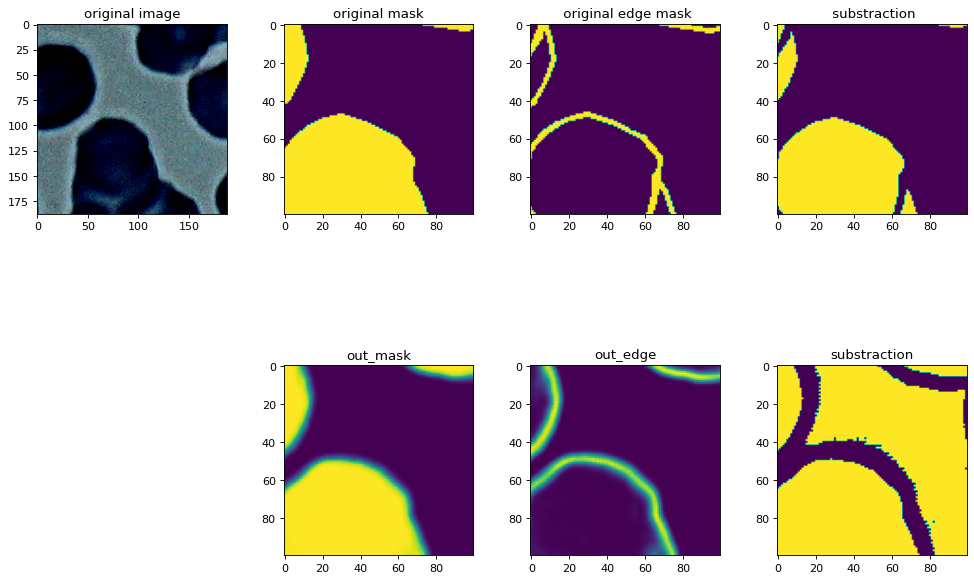

In [85]:
fig = plt.figure(figsize=(15, 10), dpi=80)
fig.subplots_adjust(hspace=0.3, wspace=0.3)
fig_num = 1
ax = fig.add_subplot(2, 4, fig_num)
ax.set_title("original image")
ax.imshow(img[0])
fig_num = fig_num + 1
ax = fig.add_subplot(2, 4, fig_num)
ax.set_title("original mask")
ax.imshow(mask)
fig_num = fig_num + 1
ax = fig.add_subplot(2, 4, fig_num)
ax.set_title(" original edge mask")
ax.imshow(edge)
fig_num = fig_num + 1
ax = fig.add_subplot(2, 4, fig_num)
ax.set_title(" substraction")
ax.imshow((mask - edge) > 0)


fig_num = fig_num + 2
ax = fig.add_subplot(2, 4, fig_num)
ax.set_title("out_mask")
ax.imshow(prediction[0])
fig_num = fig_num + 1
ax = fig.add_subplot(2, 4, fig_num)
ax.set_title("out_edge")
ax.imshow(prediction[1])
fig_num = fig_num + 1
ax = fig.add_subplot(2, 4, fig_num)
ax.set_title("substraction")
ax.imshow((prediction[0] - prediction[1]) > 0)




- predict full image

In [ ]:
images, masks, edges = model.predictFullImage(unet,
                          data.load_data_na(test_img_files),
                        padding=100,
                        input_size=188,
                        output_size=100,
                        normalize_output = False)

In [ ]:
data.plot_ime(images,
              masks,
              edges,
              figSize=(25,15))

## model training data plot

In [ ]:
hist = history.history

lines = 4
columns = 3

fig = plt.figure(figsize=(20, 20), dpi=80)
fig.subplots_adjust(hspace=0.3, wspace=0.3)
fig_num = 1
ax = fig.add_subplot(lines, columns, fig_num)
ax.set_title("mask accuracy")
ax.plot(hist['mask_acc'], label="Training")
ax.plot(hist['val_mask_acc'], label="Validation")
ax.legend()
fig_num = fig_num + 1
ax = fig.add_subplot(lines, columns, fig_num)
ax.set_title("edge mask accuracy")
ax.plot(hist['edge_acc'], label="Training")
ax.plot(hist['val_edge_acc'], label="Validation")
ax.legend()
fig_num = fig_num + 2
ax = fig.add_subplot(lines, columns, fig_num)
ax.set_title("mask loss")
ax.plot(hist['mask_loss'], label="Training")
ax.plot(hist['val_mask_loss'], label="Validation")
ax.legend()
fig_num = fig_num + 1
ax = fig.add_subplot(lines, columns, fig_num)
ax.set_title("edge loss")
ax.plot(hist['edge_loss'], label="Training")
ax.plot(hist['val_edge_loss'], label="Validation")
ax.legend()

fig_num = fig_num + 1
ax = fig.add_subplot(lines, columns, fig_num)
ax.set_title("global loss")
ax.plot(hist['loss'], label="Training")
ax.plot(hist['val_loss'], label="Validation")
ax.legend()


fig_num = fig_num + 1
ax = fig.add_subplot(lines, columns, fig_num)
ax.set_title("mask metrics")
ax.plot(hist['mask_dsc'], label="dsc")
ax.plot(hist['mask_mean_iou'], label="mean iou")
ax.plot(hist['mask_tversky'], label="tversky")
ax.plot(hist['mask_acc'], label="accuracy")

ax.set_title("mask metrics")
ax.plot(hist['val_mask_dsc'], label="val_dsc")
ax.plot(hist['val_mask_mean_iou'], label="val_mean iou")
ax.plot(hist['val_mask_tversky'], label="val_tversky")
ax.plot(hist['val_mask_acc'], label="val_accuracy")

fig_num = fig_num + 1
ax = fig.add_subplot(lines, columns, fig_num)
ax.set_title("edge metrics")
ax.plot(hist['edge_dsc'], label="dsc")
ax.plot(hist['edge_mean_iou'], label="mean iou")
ax.plot(hist['edge_tversky'], label="tversky")
ax.plot(hist['edge_acc'], label="accuracy")

ax.set_title("edge metrics")
ax.plot(hist['val_edge_dsc'], label="val_dsc")
ax.plot(hist['val_edge_mean_iou'], label="val_mean iou")
ax.plot(hist['val_edge_tversky'], label="val_tversky")
ax.plot(hist['val_edge_acc'], label="val_accuracy")
ax.legend()

## For Debugging
- show in between layers output

In [17]:
ind = np.random.randint(0, 32, 1)[0]

_pool1 = pool1[:-1,:-1,ind]
_pool2 = pool2[:-1,:-1,ind]
_pool3 = pool3[:-1,:-1,ind]
_down4 = down4[:-1,:-1,ind]
_up1 = up1[:-1,:-1,ind]
_up2 = up2[:-1,:-1,ind]
_up3 = up3[:-1,:-1,ind]

fig = plt.figure(figsize=(15, 10), dpi=80)
fig.subplots_adjust(hspace=0.3, wspace=0.3)
fig_num = 1
ax = fig.add_subplot(3, 3, fig_num)
ax.set_title("out_mask")
ax.imshow(out_mask)
fig_num = fig_num + 1
ax = fig.add_subplot(3, 3, fig_num)
ax.set_title("out_edge")
ax.imshow(out_edge)
fig_num = fig_num + 1
ax = fig.add_subplot(3, 3, fig_num)
ax.set_title("pool1")
ax.imshow(_pool1)
fig_num = fig_num + 1
ax = fig.add_subplot(3, 3, fig_num)
ax.set_title("pool2")
ax.imshow(_pool2)
fig_num = fig_num + 1
ax = fig.add_subplot(3, 3, fig_num)
ax.set_title("pool3")
ax.imshow(_pool3)
fig_num = fig_num + 1
ax = fig.add_subplot(3, 3, fig_num)
ax.set_title("down4")
ax.imshow(_down4)
fig_num = fig_num + 1
ax = fig.add_subplot(3, 3, fig_num)
ax.set_title("up1")
ax.imshow(_up1)
fig_num = fig_num + 1
ax = fig.add_subplot(3, 3, fig_num)
ax.set_title("up2")
ax.imshow(_up2)
fig_num = fig_num + 1
ax = fig.add_subplot(3, 3, fig_num)
ax.set_title("up3")
ax.imshow(_up3)

NameError: name 'pool1' is not defined

- function to plot and array of images of shape (width, height, n_images)

In [ ]:
def picshow(img, title):
    num = img.shape[2]
    imgs_per_line = 4
    ax = num//imgs_per_line + 1
    ay = imgs_per_line
    fig =plt.figure(figsize=(30, num//imgs_per_line * 10))
    fig.subplots_adjust(hspace=0.1, wspace=0.1)
    for i in range(1,num + 1):
        sub = fig.add_subplot(ax,ay,i)
        sub.set_title(f"{title} {i}")
        sub.imshow(img[:-1,:-1,i - 1])
    plt.show()
    



In [ ]:
picshow(pool1, 'pool1 ')
picshow(pool2, 'pool2 ')
picshow(pool3, 'pool3 ')
picshow(down4, 'down4 ')
picshow(up1, 'up1 ')
picshow(up2, 'up2 ')
picshow(up3, 'up3 ')